In [1]:
import transmission_line_simulator as tls
import numpy as np

# Create a curcuit

Firstly, we need to create a topology of our curcuit.
Each element has a type, a name and number of nodes characterized him.
1. element_1 = type()
2. circuit = transmission_line_system()
3. circuit.add_element(element_1, list of nodes)


In [2]:
claw = tls.capacitor()
#qubit_cap = capacitor()
#qubit_inductor = inductor()
source = tls.port()
analyzer = tls.port()

GND = tls.short()
resonator_short_end = tls.transmission_line_coupler(n=1)
resonator_claw_end = tls.transmission_line_coupler(n=1)
coupler = tls.transmission_line_coupler()

circuit = tls.transmission_line_system()

circuit.add_element(source, [1])
circuit.add_element(coupler, [1, 2, 3, 4])
circuit.add_element(analyzer, [3])
circuit.add_element(resonator_short_end, [4, 0])
circuit.add_element(resonator_claw_end, [2, 5])
circuit.add_element(claw, [5, 0])
#circuit.add_element(qubit_cap, [6, 0])
#circuit.add_element(qubit_inductor, [6, 0])
circuit.add_element(GND, [0])

source.Z0=50
analyzer.Z0=50

coupler.l=0.15e-3
coupler.Cl=np.asarray([[ 1.65604763e-10, -1.08088608e-11],
       [-1.08088608e-11,  1.65604763e-10]])
coupler.Ll=np.asarray([[5.00619333e-07, 1.08005291e-07],
       [1.08005291e-07, 5.00619333e-07]])
coupler.Rl=np.zeros(coupler.Ll.shape, dtype=np.int)
coupler.Gl=np.zeros(coupler.Ll.shape, dtype=np.int)


resonator_short_end.l = 3.6e-3
resonator_short_end.Cl = 140.453e-12
resonator_short_end.Ll = 491.157e-9
resonator_short_end.Rl = 0
resonator_short_end.Gl = 0

resonator_claw_end.l = 1.65e-3
resonator_claw_end.Cl = 140.453e-12
resonator_claw_end.Ll = 491.157e-9
resonator_claw_end.Rl = 0
resonator_claw_end.Gl = 0

claw.C=10e-15
#qubit_cap.C=70e-15
#qubit_inductor.L=19e-9

In [11]:
import scipy
from scipy.optimize import minimize_scalar

In [12]:
def equation(om_re_val, om_im_val):
        determinant = circuit.boundary_condition_matrix_det(om_re_val+1j*om_im_val)
        return (determinant.real, determinant.imag)

scale = np.asarray((2*np.pi*5.5e9, 1e6))
solution = scipy.optimize.fsolve(lambda x: equation(*(x*scale)), (1,1))*scale
fr_numeric_num = solution[0]/np.pi/2.
Q_numeric_num = -solution[0]/(2*solution[1])

In [14]:
print('full numeric frequency, GHz: ', np.abs(solution[0]/np.pi/2./1e9), ', Q: ', solution[0]/(2*solution[1]))

full numeric frequency, GHz:  5.625735614189384 , Q:  49155.500006649585


In [3]:
# Simulate scattering parameter S21

nop = 20000
frequency = np.linspace(5.624e9+0j, 5.628e9+0j, nop)
y = np.zeros(nop, dtype=complex)

matrix_of_curcuit=circuit.create_boundary_problem_matrix(frequency[0]*2*np.pi)
matrix_of_curcuit.shape
from scipy import linalg

perturbation = np.zeros((matrix_of_curcuit.shape[0],1))
perturbation[0]=10
for i in range(nop):
    matrix_of_curcuit=circuit.create_boundary_problem_matrix(frequency[i]*2*np.pi)
    s21= linalg.solve(matrix_of_curcuit, perturbation)
    y[i]=s21[2]
abs_S21 = np.abs(y)
angle_S21 = np.angle(y)

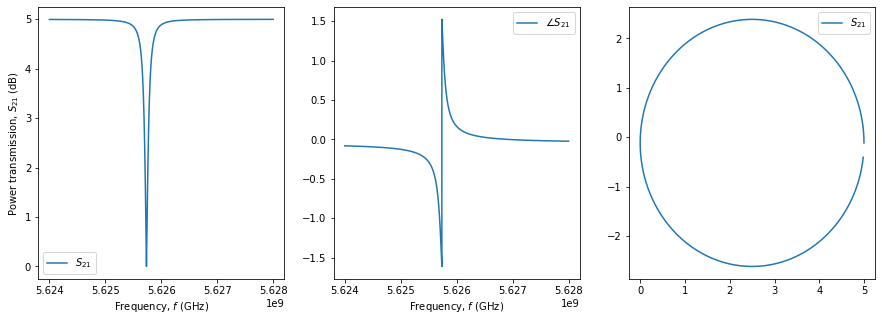

In [4]:

import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(131)
plt.plot(frequency.real, abs_S21, label = '$S_{21}$')
plt.xlabel('Frequency, $f$ (GHz)')
plt.ylabel('Power transmission, $S_{21}$ (dB)')
plt.legend()
plt.subplot(132)
plt.plot(frequency.real, angle_S21, label = '$\\angle S_{21}$')
plt.xlabel('Frequency, $f$ (GHz)')
plt.legend()
plt.subplot(133)
plt.plot(y.real, y.imag, label = '$S_{21}$')
plt.legend()
plt.show()

In [25]:
# def lorentzian(f, f_r, width, A, offset):
#     return A * width**2 /((f-f_r)**2+width**2) + offset

In [10]:
# p0 = (frequency[np.argmax(abs_S21)].real,1000,1000,10)
# p0

In [11]:
# from scipy.optimize import curve_fit
# p_opt, cov = curve_fit(lorentzian, frequency.real, abs_S21, p0 = p0)
# p_opt

In [12]:
# fig, ax = plt.subplots(figsize=(20, 10))
# plt.plot(frequency.real, abs_S21)
# plt.plot(frequency.real, lorentzian(frequency.real, *p_opt))

In [13]:
# fig.savefig("example1.png")

# Fitting using resonator_tools

In [5]:
import resonator_tools
from resonator_tools.circuit import notch_port, reflection_port

In [6]:
fitter = notch_port(f_data=frequency.real, z_data_raw=y)

In [7]:
fitter.autofit()

C:\Users\Ivan\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:447: RuntimeWarning: Number of calls to function has reached maxfev = 200.
  warnings.warn(errors[info][0], RuntimeWarning)
C:\Users\Ivan\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


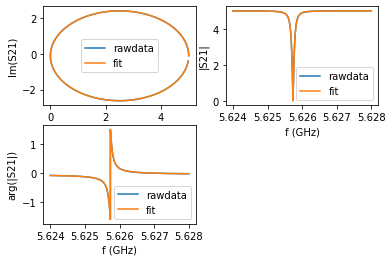

In [8]:
fitter.plotall()

In [9]:
fitter.fitresults

{'Qi_dia_corr': 26510696291.655582,
 'Qi_no_corr': -24600021379.88762,
 'absQc': 49308.55962817637,
 'Qc_dia_corr': 49308.7501749814,
 'Ql': 49308.65846300616,
 'fr': 5625735652.894433,
 'theta0': 3.1388125948260286,
 'phi0': -0.0027800587637643714,
 'phi0_err': 0.0026279419342348158,
 'Ql_err': 116.10697266976143,
 'absQc_err': 3.287178789545762,
 'fr_err': 150.07649282351773,
 'chi_square': 1.8917530661920906e-06,
 'Qi_no_corr_err': 28910673176401.773,
 'Qi_dia_corr_err': 33576640988381.223}